##  Importowanie bibliotek i wczytanie ścieżek

In [102]:
# Importowanie bibliotek
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, load_model  # Dodano `load_model`
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
import cv2

# Ścieżki do folderów z danymi
train_path2 = "./images/train-kopia/" # 3 klasy
train_path = "./images/train/" # 6 klas

val_path = "./images/validation/"

# Rozmiar obrazów
pic_size = 48

# Lista emocji (kategorii)
# Lista emocji (kategorii) - pominięcie pliku .DS_Store
emotions = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]
print("Emotions:", emotions)


Emotions: ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


## Przygotowanie danych treningowych i walidacyjnych

In [103]:
# Przygotowanie danych treningowych
train_data = []
train_labels = []

for emotion in emotions:
    emotion_path = os.path.join(train_path, emotion)
    if not os.path.isdir(emotion_path):
        continue

    for img_name in os.listdir(emotion_path):
        if img_name == '.DS_Store':
            continue

        img_path = os.path.join(emotion_path, img_name)
        img = load_img(img_path, target_size=(pic_size, pic_size), color_mode='grayscale')
        img_array = img_to_array(img)
        train_data.append(img_array)
        train_labels.append(emotions.index(emotion))  # Przypisanie etykiety numerycznej

# Przygotowanie danych walidacyjnych
val_data = []
val_labels = []

for emotion in emotions:
    emotion_path = os.path.join(val_path, emotion)
    if not os.path.isdir(emotion_path):
        continue

    for img_name in os.listdir(emotion_path):
        if img_name == '.DS_Store':
            continue

        img_path = os.path.join(emotion_path, img_name)
        img = load_img(img_path, target_size=(pic_size, pic_size), color_mode='grayscale')
        img_array = img_to_array(img)
        val_data.append(img_array)
        val_labels.append(emotions.index(emotion))  # Przypisanie etykiety numerycznej

# Normalizacja danych
train_data = np.array(train_data, dtype="float32") / 255.0
train_labels = np.array(train_labels)
val_data = np.array(val_data, dtype="float32") / 255.0
val_labels = np.array(val_labels)

# One-hot encoding etykiet
train_labels = to_categorical(train_labels, len(emotions))
val_labels = to_categorical(val_labels, len(emotions))

## Tworzenie modelu i trenowanie

In [104]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

model = Sequential()

# Warstwy konwolucyjne z BatchNormalization i Dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(pic_size, pic_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Spłaszczenie
model.add(Flatten())

# Warstwy gęste z Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Zwiększenie Dropoutu w pełnych warstwach
model.add(Dense(len(emotions), activation='softmax'))  # Wyjście: liczba emocji

# Kompilowanie modelu z innymi parametrami
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_data, train_labels, epochs=30, batch_size=32, validation_data=(val_data, val_labels))

# Ocena modelu
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Zapisanie modelu
model.save("emotion_recognition_model.keras")

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


901/901 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.2078 - loss: 2.2740 - val_accuracy: 0.3085 - val_loss: 1.7670
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.2568 - loss: 1.8092 - val_accuracy: 0.3409 - val_loss: 1.6688
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.2977 - loss: 1.7356 - val_accuracy: 0.3787 - val_loss: 1.6031
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.3276 - loss: 1.6911 - val_accuracy: 0.4021 - val_loss: 1.5459
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.3483 - loss: 1.6339 - val_accuracy: 0.4285 - val_loss: 1.4886
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.3709 - loss: 1.5898 - val_accuracy: 0.4359 - val_loss: 1.4648
Epoch 7/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.3857 - loss: 1.5575 - val_accuracy: 0.4414 - val_loss: 1.4559
Epoch 8/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.4035 - loss: 1.5203 - val_accurac

## Wczytanie modelu i funkcja predict_emotion

In [105]:
# Wczytanie zapisanego modelu
model = load_model("emotion_recognition_model.keras")

def predict_emotion(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Przekształcanie obrazu na skalę szarości
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # Ładowanie klasyfikatora twarzy
    
    # Zwiększenie wartości scaleFactor i minNeighbors, aby zmniejszyć fałszywe wykrycia
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=4, minSize=(30, 30))  # Wykrywanie twarzy
    
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]  # Wycinanie twarzy
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)  # Konwertowanie twarzy na skalę szarości
        face = cv2.resize(face, (pic_size, pic_size))  # Zmiana rozmiaru twarzy
        face = face.reshape(1, pic_size, pic_size, 1)  # Reshape twarzy do formatu (1, 48, 48, 1)
        face = face / 255.0  # Normalizacja obrazu
        
        # Przewidywanie emocji
        prediction = model.predict(face)
        max_index = np.argmax(prediction[0])
        emotion_predicted = emotions[max_index]
        
        # Wyświetlanie wyniku
        cv2.putText(frame, emotion_predicted, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return frame


## confusion matrix of our predictions

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


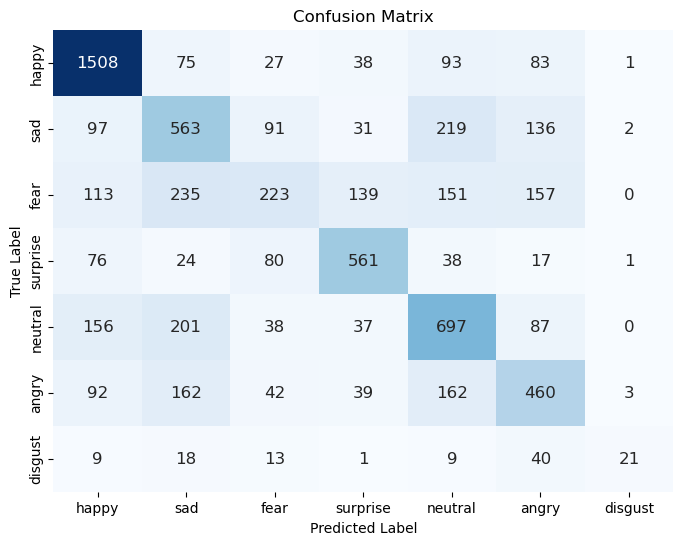

In [106]:
# Importowanie dodatkowych bibliotek
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Funkcja do obliczania macierzy pomyłek
def plot_confusion_matrix(model, val_data, val_labels, emotions):
    # Uzyskiwanie przewidywań
    val_predictions = model.predict(val_data)
    val_predictions = np.argmax(val_predictions, axis=1)  # Przewidywania w postaci indeksów

    # Uzyskiwanie prawdziwych etykiet
    val_labels = np.argmax(val_labels, axis=1)  # Konwersja one-hot encoding na indeksy

    # Obliczanie macierzy pomyłek
    cm = confusion_matrix(val_labels, val_predictions)

    # Tworzenie DataFrame dla lepszej wizualizacji
    cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)

    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Wywołanie funkcji w celu wyświetlenia macierzy pomyłek
plot_confusion_matrix(model, val_data, val_labels, emotions)


## Uruchamianie kamery

In [107]:
# Uruchomienie kamery
import time

cap = cv2.VideoCapture(2)

# Rozpoczęcie liczenia czasu
start_time = time.time()

while True:
    ret, frame = cap.read()  # Odczytanie obrazu z kamery
    if not ret:
        break
    
    # Przewidywanie emocji na obrazie
    frame = predict_emotion(frame)
    
    # Wyświetlanie obrazu z wykrytymi emocjami
    cv2.imshow('Emotion Recognition', frame)
    
    # Sprawdzanie, czy upłynęło 60 sekund
    elapsed_time = time.time() - start_time
    if elapsed_time > 60:
        break  # Przerwij po 60 sekundach

    # Zatrzymanie kamery po naciśnięciu 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()  # Zwolnienie kamery
cv2.destroyAllWindows()  # Zamykanie okien

[12/17 11:57:33.054728][info][1780248][Context.cpp:69] Context created with config: default config!
[12/17 11:57:33.054742][info][1780248][Context.cpp:74] Context work_dir=/Users/kuba/Desktop/PROJEKT ML 2/AIEmotions
[12/17 11:57:33.054760][info][1780248][Context.cpp:77] 	- SDK version: 1.9.4
[12/17 11:57:33.054761][info][1780248][Context.cpp:78] 	- SDK stage version: main
[12/17 11:57:33.054765][info][1780248][Context.cpp:82] get config EnumerateNetDevice:false
[12/17 11:57:33.054766][info][1780248][MacPal.cpp:36] createObPal: create MacPal!
[12/17 11:57:33.056395][info][1780248][MacPal.cpp:104] Create PollingDeviceWatcher!
[12/17 11:57:33.056403][info][1780248][DeviceManager.cpp:15] Current found device(s): (0)
[12/17 11:57:33.056406][info][1780248][Pipeline.cpp:15] Try to create pipeline with default device.
[12/17 11:57:33.056407][warning][1780248][ObException.cpp:5] No device found, fail to create pipeline!
[12/17 11:57:33.056732][info][1780248][Context.cpp:90] Context destroyed


OpenCV: AVFoundation didn't find any attached Video Input Devices!
OpenCV: camera failed to properly initialize!
[ WARN:0@4074.755] global cap.cpp:323 open VIDEOIO(OBSENSOR): raised unknown C++ exception!


